In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
# Dependencies
import csv
import matplotlib.pyplot as plt
import openweathermapy as ow
import pandas as pd
from pprint import pprint
from datetime import date
import json
from datetime import date
import calendar
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats

In [2]:
# Function to plot the bubble graph. It allows for changing the x, y axises and the s (area)
def bubbleplot(df, x_dim, y_dim, s_dim, classes):
   x  = df[x_dim]
   y  = df[y_dim]
   s  = df[s_dim]*20
   ct = df[classes]
   unique_city_type = ct.unique()
   ct_colors ={"Theft Over":"#FF7F50", "Robbery":"#76D7EA","Break and Enter":"#FFD700","Assault":"#A10C4D","Auto Theft":"#6195ED"}
   figsize=(10,10)
   fig, ax = plt.subplots(figsize=figsize)

   for i, city_type in enumerate(unique_city_type):
       xi = [x[j] for j  in range(len(x)) if ct[j] == city_type]
       yi = [y[j] for j  in range(len(x)) if ct[j] == city_type]
       si = [s[j] for j  in range(len(x)) if ct[j] == city_type]
       plt.scatter(x=xi, y=yi, s=si, c=ct_colors[city_type], label=str(city_type),
                   alpha=0.8, linewidths=0.5, edgecolors="black")

       #print(f"i = {i} |(xi,yi,si) points = {len(xi)} | city_type = {city_type} ")

   lgnd = plt.legend(frameon=True,title=classes,loc="upper right")
   for handle in lgnd.legendHandles:
       handle.set_sizes([20])

   ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.8)
   ax.set_title('Major Crime Indicator of Toronto Police')
   ax.set_xlabel(f'{x_dim} (Per City)')
   ax.set_ylabel(y_dim)

   note = f"Note:\nCircle size correlates to \n{s_dim}"
   plt.text(0.92, 0.5, note, fontsize=10, transform=plt.gcf().transFigure)

   #print(f"{x_dim} (min:max) ({x.min()}:{x.max()})\n{y_dim} (min:max) ({y.min()}:{y.max()})\n{s_dim} (min:max) ({s.min()}:{s.max()})")
   bubble_file_name = f"Resources/bubbleplot_{s_dim}.png"
   plt.savefig( bubble_file_name, )
   plt.show()
    

In [3]:
def expmovingaverage(values, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    a = np.convolve(values, weights)[:len(values)]
    a[:window] = a[window]
    return(a)

In [4]:
##Read the Data from already processed datafile
MCI_df = pd.read_csv("Resources/MCI_2014_to_2018_full.csv")
MCI_df.reset_index(None)
# Looking only at strikers (ST) to start
MCI_df["occurencedate_weekday"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.weekday
MCI_df["occurencedate_dayname"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.day_name()
MCI_df["occurence hour of days"]=pd.to_datetime(MCI_df["occurrencedate"],format="%Y/%m/%d").dt.hour
MCI_df["wardname"]=MCI_df['wardname'].str.strip() + ' (' + MCI_df['wardnumber'].astype(str) + ')'
MCI_df.head(5)

,Unnamed: 0,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,...,Neighbourhood,Lat,Long,ObjectId,wardnumber,wardname,wardmedian,occurencedate_weekday,occurencedate_dayname,occurence hour of days
0,0,-79.539726,43.587093,108141,GO-2015581495,2015-04-08T17:15:00.000Z,2015-04-08T20:26:00.000Z,House,2120,200,...,Long Branch (19),43.587093,-79.539726,99462,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,2,Wednesday,17
1,1,-79.539726,43.587093,151782,GO-2016401191,2016-03-06T15:00:00.000Z,2016-03-07T20:00:00.000Z,House,1430,100,...,Long Branch (19),43.587093,-79.539726,140047,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,6,Sunday,15
2,2,-79.541870,43.587353,2802,GO-20142331978,2014-06-14T20:00:00.000Z,2014-06-20T17:36:00.000Z,Outside,1430,100,...,Long Branch (19),43.587353,-79.541870,2404,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,5,Saturday,20
3,3,-79.541870,43.587353,53266,GO-20151386979,2015-08-13T03:30:00.000Z,2015-08-13T04:04:00.000Z,Outside,1430,100,...,Long Branch (19),43.587353,-79.541870,48420,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,3,Thursday,3
4,4,-79.541870,43.587353,69269,GO-20161489900,2016-08-22T23:45:00.000Z,2016-08-22T23:49:00.000Z,Outside,1420,100,...,Long Branch (19),43.587353,-79.541870,63103,Ward 6,Etobicoke-Lakeshore (Ward 6),66350.0,0,Monday,23


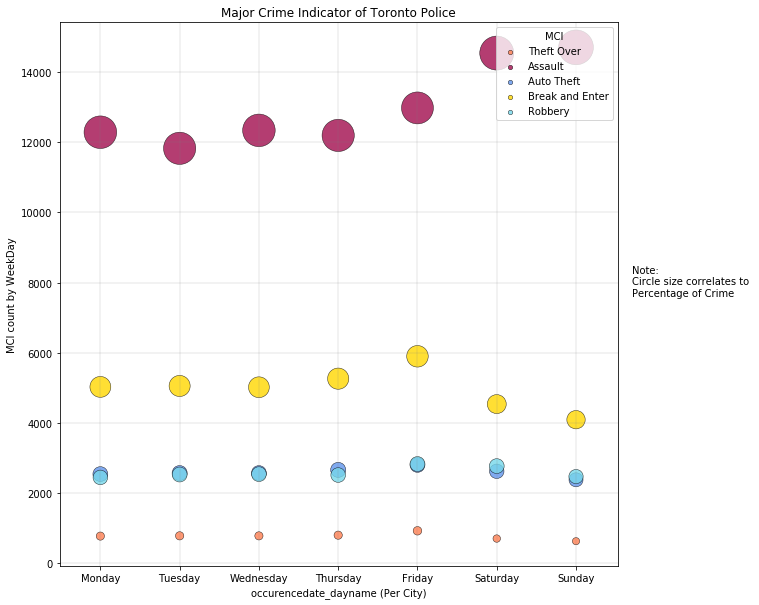

In [5]:
##Analysis for MCI indicator by days of week
total_offence = len(MCI_df)
MCI_df_Groupby_Day_and_MCI=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday","MCI"])["ObjectId"].agg([("MCI count by WeekDay","count")\
                                                                               ]).reset_index("MCI")
MCI_df_Groupby_Day=MCI_df.groupby(["occurencedate_dayname","occurencedate_weekday"])["ObjectId"].agg([("MCI sum by WeekDay","count")\
                                                                               ])
#MCI_df_Group.to_csv("Resources/Group_by_MCI.csv")
MCI_df_Groupby_all=pd.merge(MCI_df_Groupby_Day_and_MCI,MCI_df_Groupby_Day,on=["occurencedate_weekday","occurencedate_dayname"]).reset_index(None)
MCI_df_Groupby_all=MCI_df_Groupby_all.sort_values("occurencedate_weekday")
MCI_df_Groupby_all["Percentage of Crime"]=MCI_df_Groupby_all["MCI count by WeekDay"]/MCI_df_Groupby_all["MCI sum by WeekDay"]*100

MCI_df_Groupby_all=MCI_df_Groupby_all.reset_index(None)
bubbleplot(MCI_df_Groupby_all,"occurencedate_dayname","MCI count by WeekDay","Percentage of Crime","MCI")



# Null Hypothesis is no relation between crime and day of week
The p-value is lower the 0.05 hence we can reject the NULL hypothesis. THe crime and day of week is significant relationship

In [6]:
#Anova test for Days of week crime indicator(MCI)
MCI_df_anova_daysofweek=MCI_df.groupby(["MCI","occurencedate_dayname"])["ObjectId"].agg([("MCI count by WeekDay","count")])
                                                                        
MCI_df_anova_daysofweek=MCI_df_anova_daysofweek.reset_index(None)
MCI_df_anova_daysofweek=MCI_df_anova_daysofweek.set_index("MCI")
MCI_df_anova_daysofweek_pivot=MCI_df_anova_daysofweek.pivot(columns='occurencedate_dayname',values="MCI count by WeekDay")
MCI_df_anova_daysofweek_pivot
groups_days=[]
for i in range(len(MCI_df_anova_daysofweek_pivot)):
    groups_days.append([MCI_df_anova_daysofweek_pivot[y].iloc[i] for y in MCI_df_anova_daysofweek_pivot.columns])
stats.f_oneway(groups_days[0], groups_days[1], groups_days[2], groups_days[3], groups_days[4])


F_onewayResult(statistic=466.9972184056322, pvalue=1.5137362091572156e-26)

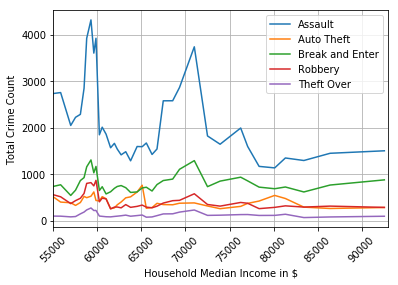

In [16]:
# Analysis by ward
MCI_df_Groupby_ward=MCI_df.groupby(["wardnumber","wardname","MCI"])["ObjectId"].agg([("MCI count by ward","count")\
                                                                              ]).join\
(MCI_df.groupby(["wardnumber","wardname","MCI"])["wardmedian"].agg([("Household Median Income","min")\
                                                                              ]))

MCI_df_Groupby_ward

MCI_df_Groupby_ward=MCI_df_Groupby_ward.reset_index(None)#("wardnumber").set_index("MCI")
MCI_df_Groupby_ward=MCI_df_Groupby_ward.set_index("MCI")

MCI_df_Groupby_ward_pivot=MCI_df_Groupby_ward.pivot(columns='Household Median Income',values="MCI count by ward")
MCI_df_Groupby_ward_pivot

for i in range(len(MCI_df_Groupby_ward_pivot)):
   mci = [k for k in MCI_df_Groupby_ward_pivot.columns],[MCI_df_Groupby_ward_pivot[y].iloc[i] for y in MCI_df_Groupby_ward_pivot.columns]
   plt.plot(expmovingaverage(mci[0], 4),expmovingaverage(mci[1], 4))
plt.legend(MCI_df_Groupby_ward_pivot.index,loc="upper right")
plt.xticks(np.arange(55000, 93000 + 5000, 5000) , rotation = 45)
plt.xlabel("Household Median Income in $")
plt.ylabel("Total Crime Count")
plt.xlim(55000, 93000)
plt.grid()
plt.savefig("Resources/Crime Analysis by Household Median Income.png")
plt.show()




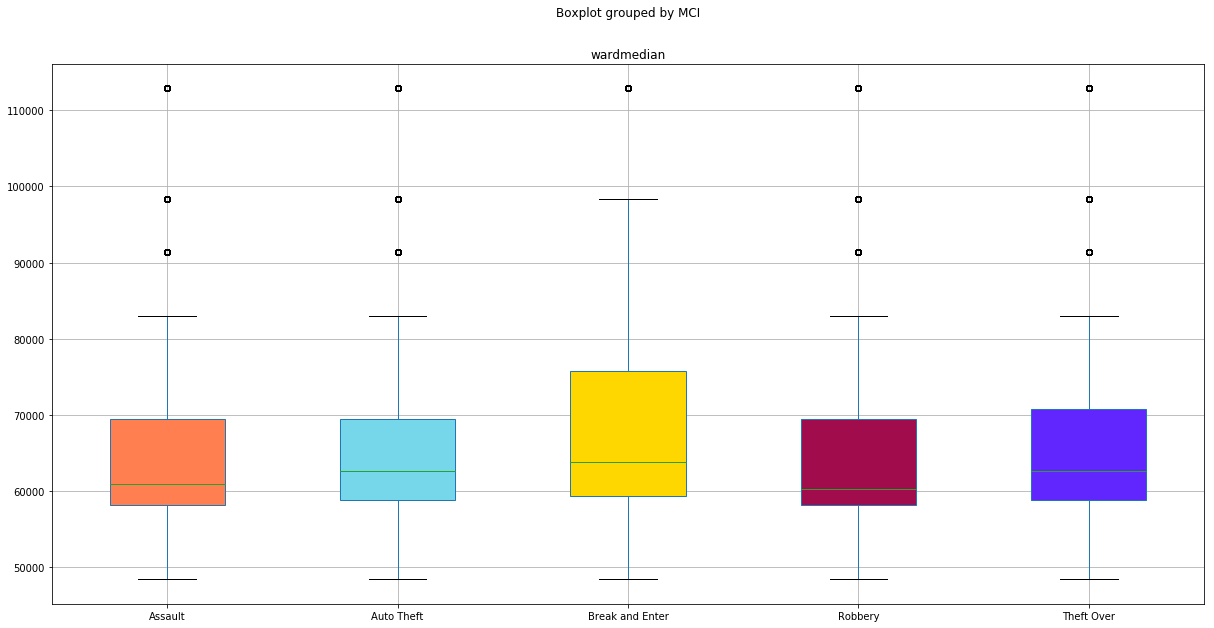

In [8]:
#Crime median based on household income

box=MCI_df.boxplot("wardmedian", by="MCI", figsize=(20, 10),return_type='both',patch_artist = True,)



colors =["#FF7F50","#76D7EA","#FFD700","#A10C4D","#6125FD"]
#colors = ['cyan', 'lightblue', 'lightgreen', 'tan', 'pink']
for row_key, (ax,row) in box.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])

plt.savefig("Resources/Crime Median Household.png")
plt.show()

# Null hypothesis  is the crime has no significance based on wards ?

P-value ≤ o.05:  you reject the null hypothesis and conclude that the crime has significance with ward

In [9]:
#Anova test for crime as per the wards

MCI_df_anova_pivot=MCI_df_Groupby_ward.pivot(columns='wardname',values="MCI count by ward")

groups=[]
for i in range(len(MCI_df_anova_pivot)):
    groups.append([MCI_df_anova_pivot[y].iloc[i] for y in MCI_df_anova_pivot.columns])
stats.f_oneway(groups[0], groups[1], groups[2], groups[3], groups[4])

F_onewayResult(statistic=58.37610293629495, pvalue=2.6781825793278318e-33)

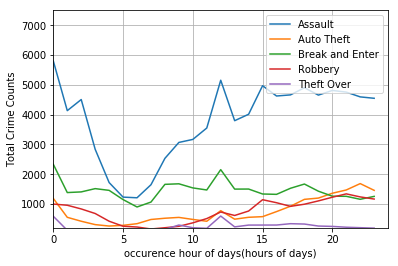

In [10]:

MCI_df_Groupby_hours=MCI_df.groupby(["occurence hour of days","MCI"])["ObjectId"].agg([("MCI count by hour","count")]).reset_index(None)
MCI_df_Groupby_hours=MCI_df_Groupby_hours.set_index("MCI")
MCI_df_Groupby_hours
MCI_df_Groupby_hours_pivot=MCI_df_Groupby_hours.pivot(columns='occurence hour of days',values="MCI count by hour")
for i in range(len(MCI_df_Groupby_hours_pivot)):
   plt.plot([k for k in MCI_df_Groupby_hours_pivot.columns],[MCI_df_Groupby_hours_pivot[y].iloc[i] for y in MCI_df_Groupby_hours_pivot.columns])
plt.legend(MCI_df_Groupby_hours_pivot.index,loc="upper right")
plt.xlim(0,24)
plt.xlabel("occurence hour of days(hours of days)")
plt.ylabel("Total Crime Counts")
plt.ylim(200,7500)
plt.grid()
plt.savefig("Resources/Crime based on hours of day.png")
plt.show()

# The Null Hypothesis is the hour of day has no significance on crime
The lower p value rejects the NULL hypothesis

In [11]:
#Anova test for occurance hour of crime

MCI_df_Groupby_hours_pivot
groups_hours=[]
for i in range(len(MCI_df_Groupby_hours_pivot)):
    groups_hours.append([MCI_df_Groupby_hours_pivot[y].iloc[i] for y in MCI_df_Groupby_hours_pivot.columns])
stats.f_oneway(groups_hours[0], groups_hours[1], groups_hours[2], groups_hours[3], groups_hours[4])


F_onewayResult(statistic=108.05844287998815, pvalue=5.150589670998093e-38)

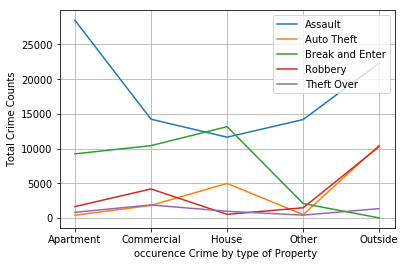

In [12]:
# Plot the premise type of 
MCI_df_Groupby_premisetype=MCI_df.groupby(["premisetype","MCI"])["ObjectId"].agg([("MCI count by premise type","count")]).reset_index(None)
MCI_df_Groupby_premisetype=MCI_df_Groupby_premisetype.set_index("MCI")

MCI_df_Groupby_premisetype_pivot=MCI_df_Groupby_premisetype.pivot(columns='premisetype',values="MCI count by premise type")

for i in range(len(MCI_df_Groupby_premisetype_pivot)):
   plt.plot([k for k in MCI_df_Groupby_premisetype_pivot.columns],[MCI_df_Groupby_premisetype_pivot[y].iloc[i] for y in MCI_df_Groupby_premisetype_pivot.columns])
plt.legend(MCI_df_Groupby_premisetype_pivot.index,loc="upper right")
plt.xlabel("occurence Crime by type of Property ")
plt.ylabel("Total Crime Counts")
plt.grid()
plt.savefig("Resources/Crime based on premise type.png")
plt.show()


# Null hypothesis is no significance of crime on type of property.

The pvalue is lower than 0.05 hence we concluded to reject the null hypothesis

In [13]:
#Anova test for Occurance of Crime by type of property
MCI_df_Groupby_premisetype_pivot
groups_days=[]
for i in range(len(MCI_df_Groupby_premisetype_pivot)):
    groups_days.append([MCI_df_Groupby_premisetype_pivot[y].iloc[i] for y in MCI_df_Groupby_premisetype_pivot.columns])
stats.f_oneway(groups_days[0], groups_days[1], groups_days[2], groups_days[3], groups_days[4])



F_onewayResult(statistic=9.843241490116789, pvalue=0.00014355566838504356)

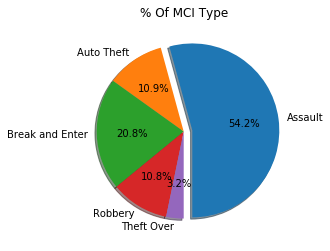

In [14]:
#Pie chart by crime 

MCI_df_crimeCount= MCI_df_household_chi_df=MCI_df.groupby(["MCI"])["ObjectId"].agg([("MCI Counts","count")\
                                                                               ]).reset_index(None)



explode = (0.1, 0, 0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

pieplt=plt.pie(MCI_df_crimeCount['MCI Counts'],explode=explode,labels=MCI_df_crimeCount['MCI'],autopct="%.1f%%",\
               shadow=True,startangle=270)

plt.title("% Of MCI Type")
plt.grid()
plt.savefig('Resources/Crime Break down.png')
plt.show()